# Voting Power, Turnout, and Persuasion in Presidential Elections

One interesting implication of the electoral college is that some individuals have more voting power than others.  This, combined with this the fact that some states are more likely to swing an election means the importance of a vote varies considerably by location.  Andrew Gelman has done [some](http://andrewgelman.com/2016/11/07/chance-vote-will-decide-election/) [work](https://pkremp.github.io/pr_decisive_vote.html) focusing on calculating the probability a voter will swing an election. Below, I ask a different but related question: "Given an election turned out the way it did, how powerful were individual voters in each state?"  This alternative metric, called the Voting Power Index, is discussed more [here](https://www.dailykos.com/stories/2016/12/19/1612252/-Voter-Power-Index-Just-How-Much-Does-the-Electoral-College-Distort-the-Value-of-Your-Vote).  Rather than rely on predicted probabilities of electoral outcomes, it simply divides the state's electoral votes by the realized vote margin:

$$state\_vpi = \frac{state\_electoral\_votes}{\lvert dem\_voters - rep\_voters\rvert}$$

I decided to take this metric a step further and calculate a county VPI, which is the fraction of the state's voting power that resides with the voting age population of each county:  

$$county\_vpi = state\_vpi*\frac{county\_vap}{state\_vap}$$

These numbers can then provide some insight on the ongoing [persuasion vs. turnout debate](https://twitter.com/Nate_Cohn/status/972608738631868416) because the county voting power can be further disaggregated by voting status:

$$persuasion\_vpi = county\_vpi*\frac{voting\_vap}{county\_vap}$$

$$turnout\_vpi = county\_vpi*\frac{nonvoting\_vap}{county\_vap}$$

This `turnout_vpi` value could hopefully act as an adjustment on the numbers from [The Missing Obama Millions](https://www.nytimes.com/2018/03/10/opinion/sunday/obama-trump-voters-democrats.html) article, which don't take the electoral college into account. To be honest, I'm mainly using this metric because it's straightforward to calculate and easy to understand.  I haven't fully considered all the implications, but it seems to produce results that are in-line with other analyses [5].  I'm definietly open to critique and could use input from a political scientist to "kick the tires" of this metric. 

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import folium
import branca.colormap as cm

import seaborn as sns

import altair as alt
from vega_datasets import data

matplotlib.style.use('ggplot') 

In [2]:
#For the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
county_df = pd.read_csv('./inputs/US_County_Level_Presidential_Results_04-16.csv', dtype={'fips_code': object})

county_df = county_df[county_df['county_name'] != 'Alaska']

In [4]:
state_df = county_df.groupby(['state','year']).agg({'vap':'sum', 'dem_num':'sum', 'rep_num':'sum', 'county_num': 'sum'})
state_df = state_df.reset_index()
state_df.rename(columns={'vap':'state_vap', 'dem_num': 'state_dem_num',
    'rep_num': 'state_rep_num', 'county_num': 'state_num'}, inplace=True)

state_df['state_dem_margin'] = (state_df['state_dem_num'] - state_df['state_rep_num']) / state_df['state_num']

#Calculate the standard deviation of the margin
state_deviation_df = state_df.groupby(['state']).agg({'state_dem_margin': 'std'})
state_deviation_df = state_deviation_df.reset_index()
state_deviation_df.rename(columns={'state_dem_margin': 'state_dem_margin_std'}, inplace=True)

state_df = pd.merge(state_df, state_deviation_df, on=['state'])

In [5]:
county_df = pd.merge(county_df, state_df, on=['state','year'])

## Initial County Dataframe

In [8]:
county_df['county_vpi'] = (county_df['vap']/county_df['state_vap'])*(county_df['state_electoral_votes']/
                    abs(county_df['state_dem_num'] - county_df['state_rep_num']))

#Rescale column so median value is 1
county_df['county_vpi'] = county_df['county_vpi']*(1/county_df['county_vpi'].median())

#The fraction of county VPI that is tapped by increasing turnout
county_df['turnout_vpi'] = ((county_df['vap'] - county_df['county_num'])/county_df['vap'])*county_df['county_vpi']

#The fraction of county VPI tapped by persuading voters to switch sides
county_df['persuasion_vpi'] = (county_df['county_num']/county_df['vap'])*county_df['county_vpi']

#Adjusting turnout for party margin
county_df['partisanturnout_vpi'] = county_df['dem_margin']*county_df['turnout_vpi']

#The advantage of turnout over persuasion in a county:
county_df['turnout_advantage'] = county_df['turnout_vpi'] - county_df['persuasion_vpi'] 

county_df = county_df.sort_values(by='county_vpi', ascending=False)

cols = ['county_name','state', 'year', 'dem_margin', 'turnout', 'turnout_vpi', 'persuasion_vpi', 'county_vpi']

county_df[cols].head(30)

#Maybe include whole table in sortable iframe here:

county_name state  year  dem_margin  turnout  turnout_vpi  \
9743      Bernalillo County    NM  2004      0.0420   0.5911  1157.042729   
9332     Saint Louis County    MO  2008      0.1990   0.7670   557.343621   
4847    Hillsborough County    NH  2016     -0.0020   0.6545   763.202291   
4849      Rockingham County    NH  2016     -0.0583   0.7383   435.852891   
9284         Jackson County    MO  2008      0.2539   0.6831   515.814695   
4390           Wayne County    MI  2016      0.3734   0.5837   539.384492   
4371         Oakland County    MI  2016      0.0811   0.6801   303.963423   
9351       Saint Louis City    MO  2008      0.6815   0.6079   335.774084   
4848       Merrimack County    NH  2016      0.0308   0.6848   259.213077   
9328   Saint Charles County    MO  2008     -0.0974   0.7592   195.964621   
9648           Clark County    NV  2004      0.0485   0.4836   419.452537   
4826           Clark County    NV  2016      0.1096   0.4527   443.659050   
9750        Dona Ana County    NM  2004      0.0357   0.5151   379.832819   
12280      Milwaukee County    WI  2004      0.2434   0.7217   197.975668   
4850       Strafford County    NH  2016      0.0856   0.6590   241.359028   
9275          Greene County    MO  2008     -0.1585   0.6661   222.883702   
4358          Macomb County    MI  2016     -0.1153   0.6148   255.384842   
9768        Santa Fe County    NM  2004      0.4321   0.6560   226.076234   
9686    Hillsborough County    NH  2004     -0.0287   0.6764   205.819444   
9766        San Juan County    NM  2004     -0.3262   0.5327   257.068508   
9765        Sandoval County    NM  2004     -0.0271   0.5356   251.487424   
9286       Jefferson County    MO  2008      0.0252   0.6630   176.088284   
9260            Clay County    MO  2008     -0.0069   0.6937   158.581377   
4846         Grafton County    NH  2016      0.1896   0.6738   166.484551   
9688      Rockingham County    NH  2004     -0.0418   0.7205   135.650672   
10090    Mecklenburg County    NC  2008      0.2437   0.7202   131.616304   
4349            Kent County    MI  2016     -0.0308   0.6372   170.557276   
7811            Polk County    IA  2004      0.0463   0.6887   145.247415   
10122           Wake County    NC  2008      0.1445   0.7990    91.760593   
4844        Cheshire County    NH  2016      0.1262   0.6652   142.008996   

       persuasion_vpi   county_vpi  
9743      1672.443141  2829.485870  
9332      1834.764478  2392.108099  
4847      1446.068221  2209.270512  
4849      1229.390599  1665.243490  
9284      1111.849170  1627.663865  
4390       756.163891  1295.548383  
4371       646.094828   950.058250  
9351       520.612544   856.386628  
4848       563.095587   822.308664  
9328       617.850926   813.815546  
9648       392.824048   812.276584  
4826       366.924796   810.583846  
9750       403.505212   783.338031  
12280      513.273876   711.249544  
4850       466.455912   707.814940  
9275       444.702308   667.586010  
4358       407.628058   663.012901  
9768       431.117576   657.193810  
9686       430.221261   636.040705  
9766       293.094828   550.163336  
9765       290.047049   541.534472  
9286       346.415216   522.503500  
9260       359.202927   517.784304  
4846       343.872287   510.356838  
9688       349.624258   485.274930  
10090      338.832514   470.448818  
4349       299.596590   470.153866  
7811       321.383619   466.631034  
10122      364.753614   456.514206  
4844       282.158481   424.167478

In [9]:
# out_cols = list(cols)
# out_cols.append('partisanturnout_vpi')
# county_df[out_cols].to_csv('./outputs/countyvpi_2004-2016.csv', index=False)

## Visualizing the County Data

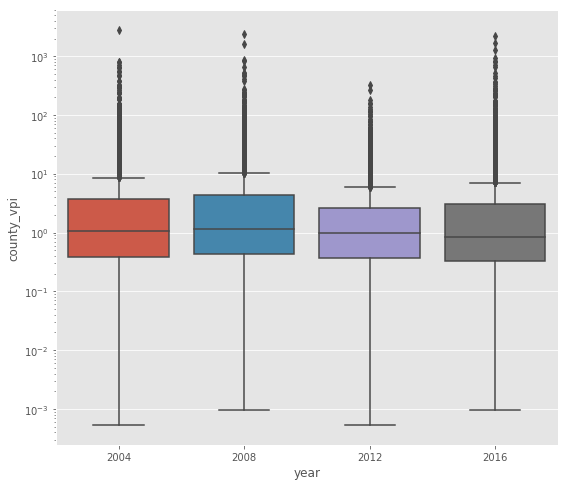

In [7]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_yscale('log')
sns.boxplot(data=county_df, x='year', y='county_vpi')  #, whis=np.inf

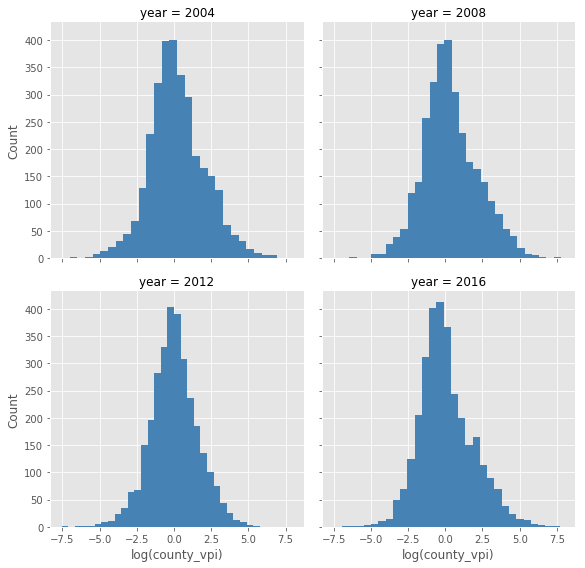

In [8]:
plt_df = county_df[['year', 'county_vpi']].copy()
plt_df['county_vpi'] = np.log(plt_df['county_vpi'])

#col="time",  col="year", col_wrap=2, size=4
g = sns.FacetGrid(plt_df,  col="year", col_wrap=2,  size=4)  
g = g.map(plt.hist, "county_vpi", bins=30, color='#4682b4')
g.set_axis_labels("log(county_vpi)", "Count")

In [9]:
map_df = county_df[['fips_code', 'county_vpi', 'year']].copy()

#Change scale so easier to see on chloropleth:
# Also available in altair, but less customizable, see here: 
# https://vega.github.io/vega-lite/docs/scale.html
map_df['county_vpi'] = np.power(map_df['county_vpi'], 0.3)

#Arrange in columns
map_df = map_df.pivot(index='fips_code', columns='year', values='county_vpi')
map_df.reset_index(inplace=True)
#Convert to ints, because the topojson strips the leading zeros
map_df['fips_code'] = map_df['fips_code'].astype(int)

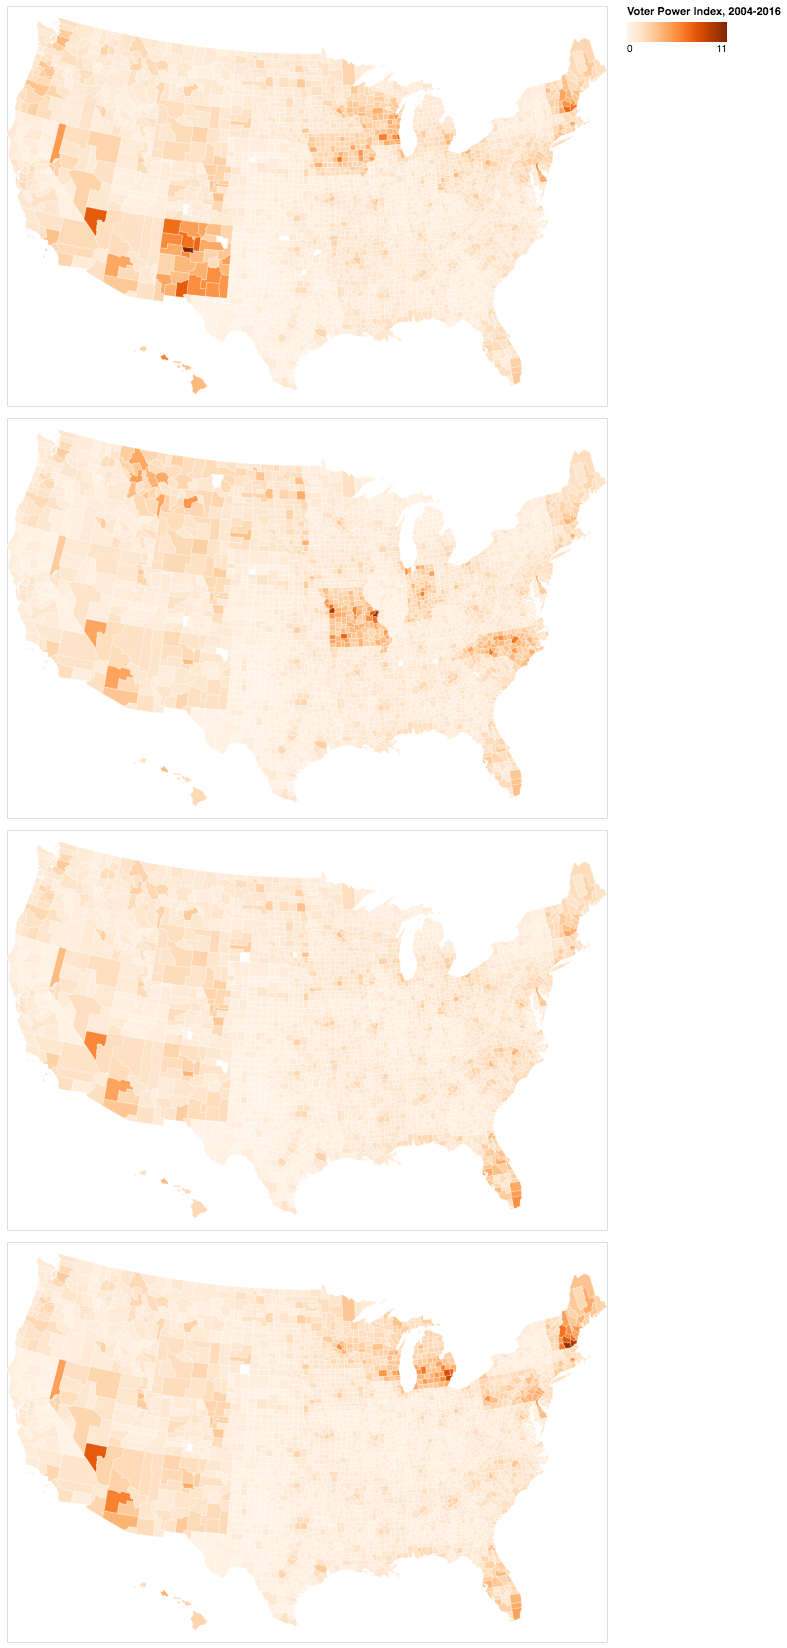

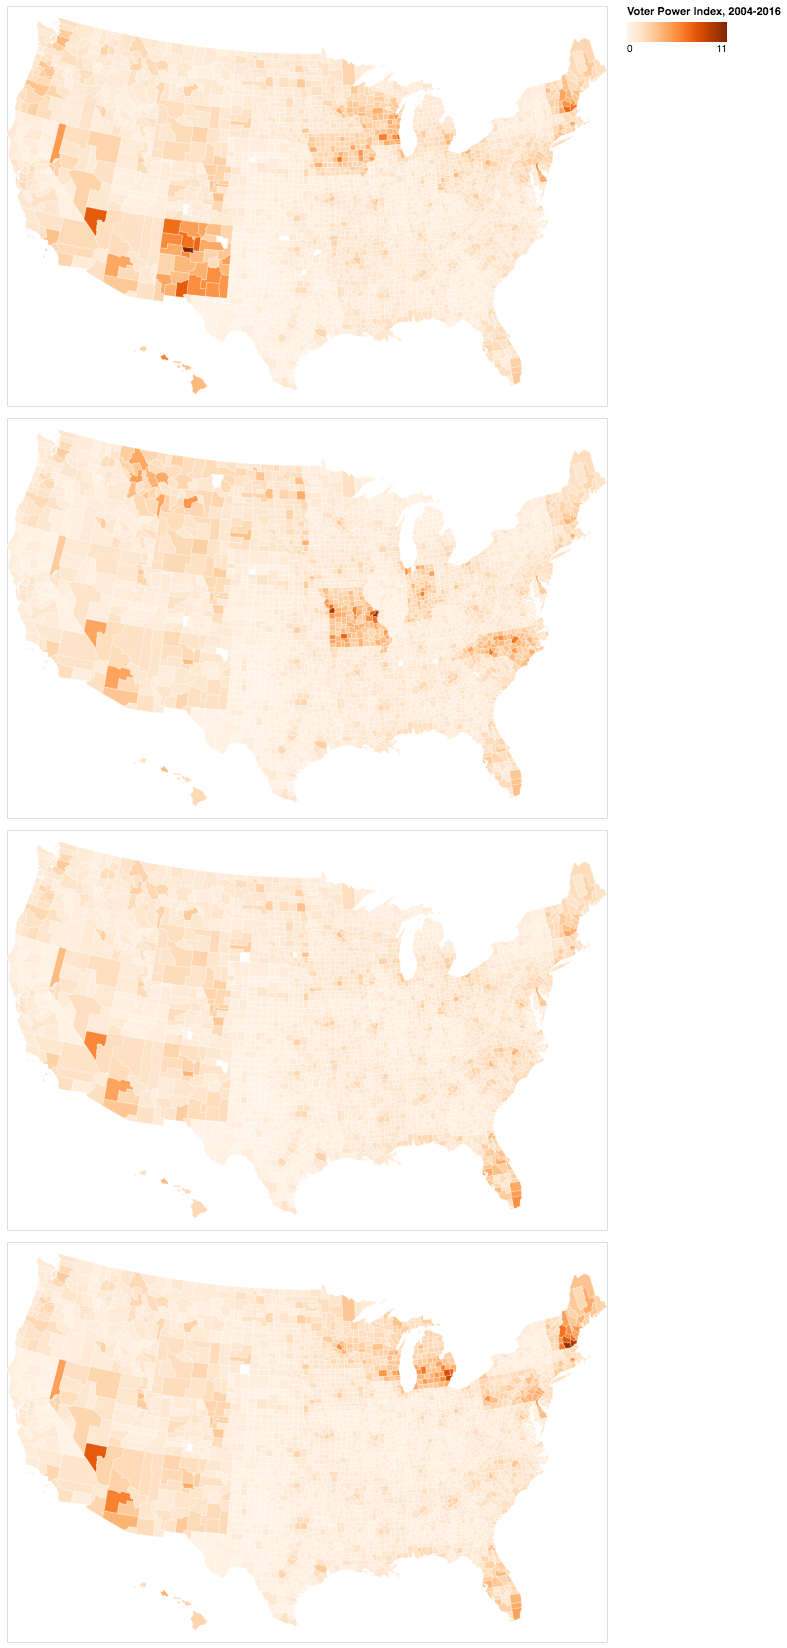

In [14]:
counties = alt.topo_feature(data.us_10m.url, 'counties')

years = ['2004', '2008', '2012', '2016']

chart = alt.Chart(
    data=counties,
).mark_geoshape(
    stroke='white',
    strokeWidth=0.25
).encode(
    alt.Color(
        alt.repeat('row'), 
        type='quantitative',
        legend=alt.Legend(title="Voter Power Index, 2004-2016"),
        scale= {"scheme": "oranges"}
    )
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(map_df, 'fips_code', years),
).project(
    type='albersUsa'
).properties(
    width=600,
    height=400
).repeat(
    row=years
)

chart.save('./outputs/vpi_2004-2016.html')

chart

## Turnout vs. Persuasion

Next, I sum the persuasion and turnout values for each election, and then calculate their ratio.  This shows that persuasion wins out in every election, but that these ratios can vary considerably.  The average pesuasion to turnout ratio is `1.6:1`, but the ratio was only `1.3:1` in 2012, a year with low turnout and few close states.  

An interesting point Nate Cohn [made](https://twitter.com/Nate_Cohn/status/972608738631868416) is that when you persuade someone, it's implied that you're probably switching their vote from an opponent.  On the face of it, this would make persuasion doubly effective:  

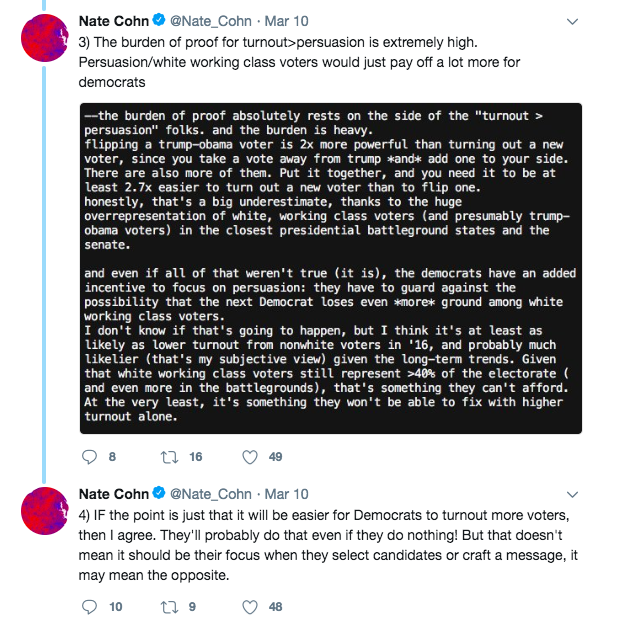 

These results are interesting, but aren't informative until we have data on the cost effectiveness of each approach, which probably depends on things like the population density and price of ad buys in different locations.  Rather than thinking in binary terms, I think it makes sense to ask which strategy is better depending on the location.  

In [16]:
yr_df = county_df.groupby(['year']) \
    .agg({'persuasion_vpi': 'sum',
          'turnout_vpi': 'sum', 'turnout_advantage':'sum'})
yr_df['ratio'] = yr_df['persuasion_vpi'] / yr_df['turnout_vpi']

yr_df

turnout_advantage   turnout_vpi  persuasion_vpi     ratio
year                                                           
2004       -7565.454805  11808.359012    19373.813817  1.640686
2008      -10075.903226  11373.802537    21449.705764  1.885887
2012       -1775.685570   5122.170093     6897.855664  1.346667
2016       -7459.669223  11810.178369    19269.847592  1.631631

In [17]:
yr_df.mean()

turnout_advantage    -6719.178206
turnout_vpi          10028.627503
persuasion_vpi       16747.805709
ratio                    1.626218
dtype: float64

## A Closer Look at 2016

Below, I select out just the 2016 values for a look at those.  One important point to make is that the VPI only shows that, given the way the election turned out, these counties were important.  It's entirely possible that a different set of counties would show up if campaigns focused on their resources elsewhere, depending on how powerful you think campaigns are.  So this 2016 data is more useful for providing a picture of what happened, rather than saying what should have been done instead.  The averages I look at later can provide more of a general picture of places that tend to be important.   

In [18]:
county2016_df = county_df[county_df['year'] == 2016]

# 'state_dem_margin',
cols_2016 = ['county_name','state', 'year', 'dem_margin',
             'turnout', 'turnout_vpi', 'persuasion_vpi', 'county_vpi',]

county2016_df[cols_2016].sort_values(by='county_vpi', ascending=False).head(30)

county_name state  year  dem_margin  turnout  turnout_vpi  \
4847  Hillsborough County    NH  2016     -0.0020   0.6545   763.202291   
4849    Rockingham County    NH  2016     -0.0583   0.7383   435.852891   
4390         Wayne County    MI  2016      0.3734   0.5837   539.384492   
4371       Oakland County    MI  2016      0.0811   0.6801   303.963423   
4848     Merrimack County    NH  2016      0.0308   0.6848   259.213077   
4826         Clark County    NV  2016      0.1096   0.4527   443.659050   
4850     Strafford County    NH  2016      0.0856   0.6590   241.359028   
4358        Macomb County    MI  2016     -0.1153   0.6148   255.384842   
4846       Grafton County    NH  2016      0.1896   0.6738   166.484551   
4349          Kent County    MI  2016     -0.0308   0.6372   170.557276   
4844      Cheshire County    NH  2016      0.1262   0.6652   142.008996   
3183      Maricopa County    AZ  2016     -0.0289   0.4787   191.532380   
6165     Milwaukee County    WI  2016      0.3701   0.6069   144.012269   
4842       Belknap County    NH  2016     -0.1678   0.7013   100.996831   
4333       Genesee County    MI  2016      0.0946   0.6238   115.104725   
4389     Washtenaw County    MI  2016      0.4128   0.6460   100.443951   
5372  Philadelphia County    PA  2016      0.6698   0.5792   115.593496   
4843       Carroll County    NH  2016     -0.0566   0.7359    71.663218   
4418      Hennepin County    MN  2016      0.3493   0.7074    74.660455   
4851      Sullivan County    NH  2016     -0.0265   0.6410    85.057186   
4257    Cumberland County    ME  2016      0.2635   0.7273    61.043883   
4341        Ingham County    MI  2016      0.2687   0.5697    96.279322   
5323     Allegheny County    PA  2016      0.1645   0.6601    75.873263   
6137          Dane County    WI  2016      0.4717   0.7387    55.366688   
4378        Ottawa County    MI  2016     -0.3047   0.6671    69.241319   
4347     Kalamazoo County    MI  2016      0.1276   0.6177    75.981134   
4845          Coos County    NH  2016     -0.0909   0.5992    70.160513   
3396    New Castle County    DE  2016      0.2960   0.5970    70.338304   
4839        Washoe County    NV  2016      0.0129   0.5729    74.024668   
3441    Miami-Dade County    FL  2016      0.2960   0.4532    92.740626   

      persuasion_vpi   county_vpi  
4847     1446.068221  2209.270512  
4849     1229.390599  1665.243490  
4390      756.163891  1295.548383  
4371      646.094828   950.058250  
4848      563.095587   822.308664  
4826      366.924796   810.583846  
4850      466.455912   707.814940  
4358      407.628058   663.012901  
4846      343.872287   510.356838  
4349      299.596590   470.153866  
4844      282.158481   424.167478  
3183      175.913839   367.446219  
6165      222.310555   366.322824  
4842      237.125381   338.122212  
4333      190.826300   305.931025  
4389      183.323358   283.767309  
5372      159.124457   274.717953  
4843      199.688143   271.351361  
4418      180.535170   255.195626  
4851      151.841761   236.898946  
4257      162.818433   223.862316  
4341      127.483898   223.763221  
5323      147.367799   223.241062  
6137      156.548600   211.915288  
4378      138.756781   207.998100  
4347      122.779735   198.760869  
4845      104.873671   175.034185  
3396      104.203257   174.541561  
4839       99.279717   173.304385  
3441       76.856905   169.597531

In [24]:
# Create Interactive Map
map_1 = folium.Map(location=[39, -96], zoom_start=4)

vpi_series = county2016_df.set_index('fips_code')['county_vpi']

colorscale = cm.LinearColormap(
    ['white', 'orange', 'red'],
    index=[0, 0.05, 1.0],
    caption = 'Voter Power Index'
).scale(0, vpi_series.max())

def style_function(feature):
    #Add leading zeros, because they're not included
    feature['id'] = feature['id'].zfill(5)
    vpi = vpi_series.get(feature['id'], None)
    return {
        'fillOpacity': 0.8,
        'weight': 0.05,
        'fillColor': "#ffffff" if vpi is None else colorscale(vpi)
    }

folium.GeoJson(
    open('./inputs/us-counties.json').read(),
    style_function=style_function,
    name='2016'
).add_to(map_1)

map_1.save('./outputs/vpi_folium-2016.html')

map_1

In [20]:
#Important counties for Democrats, in states they lost:
county2016_df[(county2016_df['state_dem_margin'] < 0)] \
    .sort_values(by='county_vpi', ascending=False)[cols_2016].head(20)
#Important counties for Democrats, in states with margins within 1 standard deviation
# county2016_df[(county2016_df['state_dem_margin']  < 0)] \
#     .sort_values(by='county_vpi', ascending=False).head(50)

county_name state  year  dem_margin  turnout  turnout_vpi  \
4390         Wayne County    MI  2016      0.3734   0.5837   539.384492   
4371       Oakland County    MI  2016      0.0811   0.6801   303.963423   
4358        Macomb County    MI  2016     -0.1153   0.6148   255.384842   
4349          Kent County    MI  2016     -0.0308   0.6372   170.557276   
3183      Maricopa County    AZ  2016     -0.0289   0.4787   191.532380   
6165     Milwaukee County    WI  2016      0.3701   0.6069   144.012269   
4333       Genesee County    MI  2016      0.0946   0.6238   115.104725   
4389     Washtenaw County    MI  2016      0.4128   0.6460   100.443951   
5372  Philadelphia County    PA  2016      0.6698   0.5792   115.593496   
4341        Ingham County    MI  2016      0.2687   0.5697    96.279322   
5323     Allegheny County    PA  2016      0.1645   0.6601    75.873263   
6137          Dane County    WI  2016      0.4717   0.7387    55.366688   
4378        Ottawa County    MI  2016     -0.3047   0.6671    69.241319   
4347     Kalamazoo County    MI  2016      0.1276   0.6177    75.981134   
3441    Miami-Dade County    FL  2016      0.2960   0.4532    92.740626   
6192      Waukesha County    WI  2016     -0.2649   0.7690    36.264767   
4381       Saginaw County    MI  2016     -0.0114   0.6276    54.409449   
5367    Montgomery County    PA  2016      0.2128   0.6807    46.131019   
4355    Livingston County    MI  2016     -0.2956   0.7180    40.418475   
4369      Muskegon County    MI  2016      0.0151   0.5879    53.208862   

      persuasion_vpi   county_vpi  
4390      756.163891  1295.548383  
4371      646.094828   950.058250  
4358      407.628058   663.012901  
4349      299.596590   470.153866  
3183      175.913839   367.446219  
6165      222.310555   366.322824  
4333      190.826300   305.931025  
4389      183.323358   283.767309  
5372      159.124457   274.717953  
4341      127.483898   223.763221  
5323      147.367799   223.241062  
6137      156.548600   211.915288  
4378      138.756781   207.998100  
4347      122.779735   198.760869  
3441       76.856905   169.597531  
6192      120.708511   156.973278  
4381       91.691815   146.101264  
5367       98.363149   144.494168  
4355      102.916091   143.334567  
4369       75.912113   129.120974

In [21]:
# Where was more turnout especially important for democrats?  
# This multiplies the democratic margin for the county times 
# the fraction of county's voting power that resided with non-voters
# in states that democrats lost:
temp_cols = list(cols_2016)
temp_cols.append('partisanturnout_vpi')

county2016_df[(county2016_df['state_dem_margin'] < 0)] \
    .sort_values(by='partisanturnout_vpi', ascending=False) \
    [temp_cols].head(20)

county_name state  year  dem_margin  turnout  turnout_vpi  \
4390         Wayne County    MI  2016      0.3734   0.5837   539.384492   
5372  Philadelphia County    PA  2016      0.6698   0.5792   115.593496   
6165     Milwaukee County    WI  2016      0.3701   0.6069   144.012269   
4389     Washtenaw County    MI  2016      0.4128   0.6460   100.443951   
3441    Miami-Dade County    FL  2016      0.2960   0.4532    92.740626   
6137          Dane County    WI  2016      0.4717   0.7387    55.366688   
4341        Ingham County    MI  2016      0.2687   0.5697    96.279322   
4371       Oakland County    MI  2016      0.0811   0.6801   303.963423   
3404       Broward County    FL  2016      0.3514   0.5507    53.225032   
5323     Allegheny County    PA  2016      0.1645   0.6601    75.873263   
4333       Genesee County    MI  2016      0.0946   0.6238   115.104725   
5367    Montgomery County    PA  2016      0.2128   0.6807    46.131019   
4347     Kalamazoo County    MI  2016      0.1276   0.6177    75.981134   
3446        Orange County    FL  2016      0.2465   0.5331    37.509184   
3509        DeKalb County    GA  2016      0.6397   0.5486    12.546856   
3525        Fulton County    GA  2016      0.4163   0.5436    17.638595   
5344      Delaware County    PA  2016      0.2229   0.6805    31.517100   
3448    Palm Beach County    FL  2016      0.1544   0.5674    39.589691   
3186          Pima County    AZ  2016      0.1383   0.5184    44.010083   
5027   Mecklenburg County    NC  2016      0.2941   0.5899    18.240876   

      persuasion_vpi   county_vpi  partisanturnout_vpi  
4390      756.163891  1295.548383           201.406169  
5372      159.124457   274.717953            77.424524  
6165      222.310555   366.322824            53.298941  
4389      183.323358   283.767309            41.463263  
3441       76.856905   169.597531            27.451225  
6137      156.548600   211.915288            26.116467  
4341      127.483898   223.763221            25.870254  
4371      646.094828   950.058250            24.651434  
3404       65.232522   118.457554            18.703276  
5323      147.367799   223.241062            12.481152  
4333      190.826300   305.931025            10.888907  
5367       98.363149   144.494168             9.816681  
4347      122.779735   198.760869             9.695193  
3446       42.832926    80.342110             9.246014  
3509       15.246383    27.793239             8.026224  
3525       21.007978    38.646573             7.342947  
5344       67.122985    98.640085             7.025162  
3448       51.932850    91.522541             6.112648  
3186       47.380936    91.391018             6.086594  
5027       26.238808    44.479683             5.364642

# County Averages, 2004-2016

The above 2016 analysis is interesting but if we want values that are more generalizable to future elections it makes sense to look at averages.  If you average over too few elections you risk overfitting to a specific point in time, but averaging over too many years will make the results irrelevant to the present.  I was only able to compile data from 2004 forward anyways, so these are the years I went with.   

In [21]:
# Which counties, on average across all elections, have highest VPIs?   
# fips codes changed?:'county_name', 'state' , 'fips_code'
# county names aren't consistent: 'county_name', 
avg_df = county_df.groupby(['state', 'fips_code']) \
    .agg({'county_vpi':'mean',
        'vap':'mean',
        'turnout_vpi': 'mean',
        'dem_margin': 'mean',
        'turnout': 'mean',
        'county_vpi': 'mean',
        'persuasion_vpi':'mean', 
        'partisanturnout_vpi': 'mean',
        'turnout_advantage': 'mean',
        'state_dem_margin': 'mean',
        'state_dem_margin_std': 'mean'})
    
avg_df = avg_df.reset_index()
#avg_df['fips_code'].count() #3114
countynames_df = county2016_df[['county_name', 'fips_code']]
avg_df = avg_df.merge(countynames_df, how='left', on='fips_code')

#avg_df['fips_code'].count() #3114
avg_cols = ['county_name','state', 'dem_margin',
    'turnout', 'turnout_vpi', 'persuasion_vpi', 'county_vpi']

avg_df[avg_cols].sort_values(by='county_vpi', ascending=False).head(30)


county_name state  dem_margin   turnout  turnout_vpi  \
1901        Bernalillo County    NM    0.149150  0.574300   322.191780   
1875      Hillsborough County    NH    0.004500  0.673875   261.531237   
1466  St. Louis County County    MO    0.147975  0.713775   146.267445   
1877        Rockingham County    NH   -0.033725  0.736700   154.517507   
1935             Clark County    NV    0.123775  0.491850   274.776186   
1418           Jackson County    MO    0.198300  0.625425   135.126185   
1282             Wayne County    MI    0.432750  0.613300   148.977818   
1876         Merrimack County    NH    0.086950  0.690625    91.522184   
3004         Milwaukee County    WI    0.333100  0.681100    89.948122   
1263           Oakland County    MI    0.077700  0.722425    82.209028   
1878         Strafford County    NH    0.138775  0.653925    85.666172   
1485    St. Louis City County    MO    0.648300  0.562800    87.590113   
1908          Dona Ana County    NM    0.134450  0.487375   106.915843   
1462       St. Charles County    MO   -0.186850  0.691450    51.804907   
149           Maricopa County    AZ   -0.096975  0.504300   102.560581   
1250            Macomb County    MI   -0.001075  0.646625    69.591618   
1927          Santa Fe County    NM    0.500950  0.638625    62.969974   
1874           Grafton County    NH    0.207425  0.695250    56.945682   
289         New Castle County    DE    0.315725  0.629775    64.782894   
1409            Greene County    MO   -0.230925  0.603550    58.499603   
518           Honolulu County    HI    0.282000  0.424475    87.682310   
2976              Dane County    WI    0.426900  0.766800    37.693819   
1683       Mecklenburg County    NC    0.199550  0.623500    46.769953   
1872          Cheshire County    NH    0.210625  0.679900    49.880695   
1925          San Juan County    NM   -0.286475  0.532225    70.316299   
1924          Sandoval County    NM    0.045575  0.587850    68.888435   
1715              Wake County    NC    0.109925  0.694975    34.137508   
597               Polk County    IA    0.111850  0.689775    44.707537   
1420         Jefferson County    MO   -0.115050  0.613525    46.144611   
1394              Clay County    MO   -0.067175  0.635425    41.664370   

      persuasion_vpi  county_vpi  
1901      458.901725  781.093505  
1875      509.284778  770.816015  
1466      475.652972  621.920417  
1877      427.941955  582.459462  
1935      247.379861  522.156047  
1418      287.882299  423.008484  
1282      212.273072  361.250891  
1876      198.694873  290.217058  
3004      193.970429  283.918551  
1263      179.036279  261.245307  
1878      161.759279  247.425451  
1485      134.671075  222.261188  
1908      111.046813  217.962656  
1462      160.086089  211.890996  
149       101.472468  204.033050  
1250      112.881508  182.473126  
1927      118.248456  181.218430  
1874      121.479588  178.425270  
289       109.726453  174.509347  
1409      115.185390  173.684993  
518        69.460802  157.143112  
2976      118.256630  155.950449  
1683      105.776832  152.546785  
1872      101.502992  151.383687  
1925       80.104796  150.421096  
1924       81.126173  150.014608  
1715      114.221262  148.358770  
597        99.109343  143.816880  
1420       89.681424  135.826035  
1394       93.034411  134.698781

In [25]:
# Create map
map_2 = folium.Map(location=[39, -96], zoom_start=4)

vpi_series = avg_df.set_index('fips_code')['county_vpi']

colorscale = cm.LinearColormap(
    ['white', 'orange', 'red'], 
    index=[0, 0.1, 1.0]
).scale(0, vpi_series.max())

def style_function(feature):
    #Add leading zeros, because they're not included for all GeoJson
    feature['id'] = feature['id'].zfill(5)
    vpi = vpi_series.get(feature['id'], None)
    return {
        'fillOpacity': 0.8,
        'weight': 0.05,
        'fillColor': "#ffffff" if vpi is None else colorscale(vpi)
    }

county_geo = './inputs/us-counties.json'

folium.GeoJson(
    open(county_geo).read(), style_function=style_function
).add_to(map_2)


folium.LayerControl().add_to(map_2)
# Save as index.html
map_2.save('./outputs/vpi_folium-2004-2016.html')

map_2 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10d57dbe0>], dtype=object)

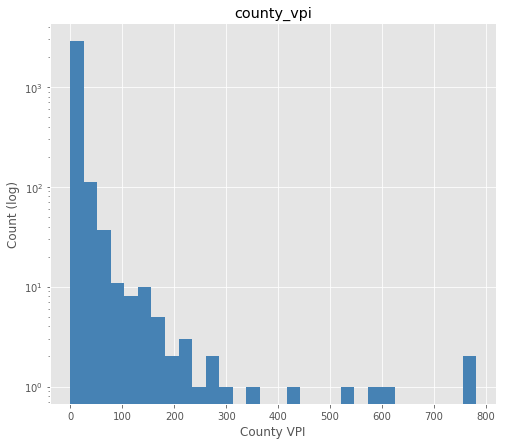

In [23]:
fig, ax = plt.subplots(figsize=(8,7))
plt.title('')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('County VPI')
ax.set_ylabel('Count (log)')
avg_df.hist(column='county_vpi', bins=30, ax=ax, color='#4682b4')  #bins=10, , bottom=0.1

In [26]:
#So let's repeat the same analysis as above using these average values now. 
# Counties that are cruicial for Democrats in states that they lose, or are often close: #0.05
# avg_df[avg_df['state_dem_margin'] < 0.05] \
#     .sort_values(by='county_vpi', ascending=False) \
#     [avg_cols].head(30)
# Note that at a cutoff of 0.05, WI and MI are left out, which might provide some insight
# into why they weren't the focus of the 2016 campaign, although their average margin
# is still within a standard deviation of 0:  

#Using stdev as cutoff:
avg_df[(avg_df['state_dem_margin'] - avg_df['state_dem_margin_std'])  < 0] \
    .sort_values(by='county_vpi', ascending=False) \
    [avg_cols].head(30)

county_name state  dem_margin   turnout  turnout_vpi  \
1875      Hillsborough County    NH    0.004500  0.673875   261.531237   
1466  St. Louis County County    MO    0.147975  0.713775   146.267445   
1877        Rockingham County    NH   -0.033725  0.736700   154.517507   
1935             Clark County    NV    0.123775  0.491850   274.776186   
1418           Jackson County    MO    0.198300  0.625425   135.126185   
1282             Wayne County    MI    0.432750  0.613300   148.977818   
1876         Merrimack County    NH    0.086950  0.690625    91.522184   
3004         Milwaukee County    WI    0.333100  0.681100    89.948122   
1263           Oakland County    MI    0.077700  0.722425    82.209028   
1878         Strafford County    NH    0.138775  0.653925    85.666172   
1485    St. Louis City County    MO    0.648300  0.562800    87.590113   
1462       St. Charles County    MO   -0.186850  0.691450    51.804907   
149           Maricopa County    AZ   -0.096975  0.504300   102.560581   
1250            Macomb County    MI   -0.001075  0.646625    69.591618   
1874           Grafton County    NH    0.207425  0.695250    56.945682   
1409            Greene County    MO   -0.230925  0.603550    58.499603   
2976              Dane County    WI    0.426900  0.766800    37.693819   
1683       Mecklenburg County    NC    0.199550  0.623500    46.769953   
1872          Cheshire County    NH    0.210625  0.679900    49.880695   
1715              Wake County    NC    0.109925  0.694975    34.137508   
597               Polk County    IA    0.111850  0.689775    44.707537   
1420         Jefferson County    MO   -0.115050  0.613525    46.144611   
1394              Clay County    MO   -0.067175  0.635425    41.664370   
333         Miami-Dade County    FL    0.189300  0.530975    70.069633   
1241              Kent County    MI   -0.072175  0.676250    46.230380   
3031          Waukesha County    WI   -0.304775  0.806300    23.639061   
1870           Belknap County    NH   -0.081125  0.698725    36.262529   
814             Marion County    IN    0.188175  0.543075    46.917241   
1948            Washoe County    NV    0.033750  0.595925    49.434472   
2264      Philadelphia County    PA    0.665325  0.609925    42.629915   

      persuasion_vpi  county_vpi  
1875      509.284778  770.816015  
1466      475.652972  621.920417  
1877      427.941955  582.459462  
1935      247.379861  522.156047  
1418      287.882299  423.008484  
1282      212.273072  361.250891  
1876      198.694873  290.217058  
3004      193.970429  283.918551  
1263      179.036279  261.245307  
1878      161.759279  247.425451  
1485      134.671075  222.261188  
1462      160.086089  211.890996  
149       101.472468  204.033050  
1250      112.881508  182.473126  
1874      121.479588  178.425270  
1409      115.185390  173.684993  
2976      118.256630  155.950449  
1683      105.776832  152.546785  
1872      101.502992  151.383687  
1715      114.221262  148.358770  
597        99.109343  143.816880  
1420       89.681424  135.826035  
1394       93.034411  134.698781  
333        62.784885  132.854518  
1241       82.839295  129.069675  
3031       96.444778  120.083840  
1870       83.674006  119.936536  
814        71.846952  118.764192  
1948       69.178636  118.613108  
2264       61.745824  104.375739

In [27]:
# Where is more turnout on average important for democrats?  
# This multiplies the average democratic margin for the county times 
# the fraction of county's voting power that resides with non-voters
# in states that democrats lose on average:
temp_cols = list(avg_cols)
temp_cols.append('partisanturnout_vpi')

# Hard cutoff
# avg_df[(avg_df['state_dem_margin'] < 0.05)] \
#     .sort_values(by='partisanturnout_vpi', ascending=False) \
#     [temp_cols].head(20)

# Using standard deviation as cutoff:
avg_df[(avg_df['state_dem_margin'] - avg_df['state_dem_margin_std'])  < 0] \
    .sort_values(by='partisanturnout_vpi', ascending=False) \
    [temp_cols].head(20)

county_name state  dem_margin   turnout  turnout_vpi  \
1485    St. Louis City County    MO    0.648300  0.562800    87.590113   
1282             Wayne County    MI    0.432750  0.613300   148.977818   
1418           Jackson County    MO    0.198300  0.625425   135.126185   
1466  St. Louis County County    MO    0.147975  0.713775   146.267445   
2264      Philadelphia County    PA    0.665325  0.609925    42.629915   
3004         Milwaukee County    WI    0.333100  0.681100    89.948122   
1935             Clark County    NV    0.123775  0.491850   274.776186   
333         Miami-Dade County    FL    0.189300  0.530975    70.069633   
2976              Dane County    WI    0.426900  0.766800    37.693819   
296            Broward County    FL    0.335900  0.597550    41.629796   
814             Marion County    IN    0.188175  0.543075    46.917241   
1683       Mecklenburg County    NC    0.199550  0.623500    46.769953   
1281         Washtenaw County    MI    0.364925  0.678475    27.339354   
1874           Grafton County    NH    0.207425  0.695250    56.945682   
810               Lake County    IN    0.271225  0.557900    27.210686   
1878         Strafford County    NH    0.138775  0.653925    85.666172   
1872          Cheshire County    NH    0.210625  0.679900    49.880695   
231             Denver County    CO    0.491850  0.631100    15.214315   
1233            Ingham County    MI    0.261250  0.618050    26.172508   
2030          Cuyahoga County    OH    0.367400  0.669800    17.778616   

      persuasion_vpi  county_vpi  partisanturnout_vpi  
1485      134.671075  222.261188            59.512773  
1282      212.273072  361.250891            56.343820  
1418      287.882299  423.008484            33.846646  
1466      475.652972  621.920417            28.579127  
2264       61.745824  104.375739            28.265886  
3004      193.970429  283.918551            26.973063  
1935      247.379861  522.156047            26.547873  
333        62.784885  132.854518            16.912560  
2976      118.256630  155.950449            14.620923  
296        54.008480   95.638276            14.402219  
814        71.846952  118.764192            12.542131  
1683      105.776832  152.546785            11.133419  
1281       50.613277   77.952632            11.065435  
1874      121.479588  178.425270            10.346608  
810        39.655590   66.866276             9.038743  
1878      161.759279  247.425451             8.503564  
1872      101.502992  151.383687             7.501982  
231        25.033011   40.247326             7.348741  
1233       35.480233   61.652741             6.918139  
2030       37.946032   55.724648             6.505297

## State Averages, 2004-2016

In [28]:
#Finally, a look at which states have the highest VPIs on average:
stateavg_df = avg_df.groupby(['state']) \
    .agg({'county_vpi':'sum', 'state_dem_margin': 'mean',
          'state_dem_margin_std': 'mean'})
    
stateavg_df = stateavg_df.reset_index()
stateavg_df.rename(columns={'county_vpi': 'state_vpi'}, inplace=True)

#state2016_df.head()
stateavg_df.sort_values(by='state_vpi', ascending=False) \
    [['state', 'state_dem_margin', 'state_dem_margin_std', 'state_vpi']]

state  state_dem_margin  state_dem_margin_std    state_vpi
23    MO         -0.088309              0.076329  3723.507729
29    NH          0.042422              0.042528  2583.739105
31    NM          0.082859              0.064740  2420.283067
21    MI          0.072843              0.073145  2081.528255
47    WI          0.051164              0.067599  1762.649753
26    NC         -0.044506              0.055681  1689.238845
11    IA          0.013179              0.083005  1068.553786
8     FL         -0.006281              0.033483  1047.400807
37    PA          0.043789              0.046965   875.171984
14    IN         -0.123273              0.097718   873.010964
32    NV          0.047860              0.064288   733.761064
25    MT         -0.142498              0.087199   517.434294
22    MN          0.057319              0.039571   507.139352
34    OH         -0.006852              0.055957   500.556711
20    ME          0.109764              0.065559   416.638357
2     AZ         -0.079020              0.030036   342.266591
4     CO          0.036412              0.058286   331.796870
44    VA          0.018062              0.067559   318.843362
7     DE          0.156620              0.077219   292.939386
9     GA         -0.086934              0.054129   288.144129
27    ND         -0.228343              0.115341   272.820570
40    SD         -0.194021              0.088569   259.209226
36    OR          0.108927              0.050525   225.742887
10    HI          0.321944              0.166591   223.493998
38    RI          0.228223              0.063615   216.777214
48    WV         -0.235889              0.136793   187.958074
39    SC         -0.127968              0.035746   186.380243
45    VT          0.298291              0.079442   172.258431
30    NJ          0.134955              0.047948   169.003730
42    TX         -0.148490              0.060181   167.444501
24    MS         -0.155411              0.038428   163.852290
1     AR         -0.200546              0.074477   162.990378
46    WA          0.137353              0.044792   155.471282
49    WY         -0.396539              0.055923   154.001139
5     CT          0.159225              0.051560   149.951731
28    NE         -0.238572              0.076248   143.174601
17    LA         -0.174428              0.023537   127.490992
15    KS         -0.207398              0.043104   127.423478
41    TN         -0.189735              0.054267   125.180037
13    IL          0.173189              0.060589   122.598985
3     CA          0.217719              0.084518   116.419163
16    KY         -0.221563              0.057683   104.420891
12    ID         -0.317518              0.051835    99.442684
19    MD          0.227307              0.065130    94.385269
0     AL         -0.242762              0.029066    92.337821
43    UT         -0.349195              0.142572    90.717261
33    NY          0.239724              0.044825    87.296743
35    OK         -0.331157              0.024607    75.709216
18    MA          0.252962              0.017399    73.806510
6     DC          0.840280              0.030791    66.658087

## Conclusion

* Voting power is lognormally distributed, so some counties/voters are much more powerful than others. 

* Certain locations in NH, NM, MO, NV, MI, WI, PA, and FL repeatedly top the list. 
  
* At least according to this metric, persuasion has more power than turnout (an average 1.6:1 ratio), but the cost of each approach needs to be considered before drawing any conclusions.

* It seems like it would be a good idea to use something like the Voting Power Index as the baseline, then update away from it using current polling numbers during an election.  That way, you'd need very strong evidence to ignore places like WI or MI.    

## Next steps

This analysis only considers the power of a location in the presidential elections, but Senate, House and State Level elections are crucial too.  It wouldn't be very hard to include results from Senate elections as those are statewide, but House districts don't match county lines and have ever-changing boundaries.  As a result, it would be hard to get Voting Age Population data, and then distribute the voting power amongst the counties.

One thing I could do is create a [synthetic population](https://github.com/UDST/synthpop) of the US using census data.  I could then distribute voting power to every individual based on their location in Presidential, Congressional and State elections, then aggregate it by any boundary I choose.  I'd need accurate district boundaries and results for every election along with some model of how power is shared across branches of government to make this work though. . .  
  
  
## References

[1] What is the chance that your vote will decide the election? Ask Stan! [http://andrewgelman.com/2016/11/07/chance-vote-will-decide-election/](http://andrewgelman.com/2016/11/07/chance-vote-will-decide-election/)

[2] What is the Chance That Your Vote Will Decide the Election? [https://pkremp.github.io/pr_decisive_vote.html](https://pkremp.github.io/pr_decisive_vote.html)

[3] Nate Cohn.  [https://twitter.com/Nate_Cohn/status/972608738631868416](https://twitter.com/Nate_Cohn/status/972608738631868416)

[4] The Missing Obama Millions.  [https://www.nytimes.com/2018/03/10/opinion/sunday/obama-trump-voters-democrats.html](https://www.nytimes.com/2018/03/10/opinion/sunday/obama-trump-voters-democrats.html)

[5] Voter Power Index: Just How Much Does the Electoral College Distort the Value of Your Vote?  [https://www.dailykos.com/stories/2016/12/19/1612252/-Voter-Power-Index-Just-How-Much-Does-the-Electoral-College-Distort-the-Value-of-Your-Vote](https://www.dailykos.com/stories/2016/12/19/1612252/-Voter-Power-Index-Just-How-Much-Does-the-Electoral-College-Distort-the-Value-of-Your-Vote)

[6] Synthpop: Synthetic populations from census data.  [https://github.com/UDST/synthpop](https://github.com/UDST/synthpop)
